In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Variable Definitions

#### E   = event identity stamp
#### T   = event time stamp

### Event Stamps ( array E )

##### 5   = Pellet reinforcement delivery
##### 6   = Food tray head entry
##### 100 = Session termination

- 1   = Rt lever press/NP
- 2   = Lt lever press/NP
- 7   = Right cue light on
- 8   = Left cue light on
- 9   = Right cue light off
- 10  = Left cue ight off
- 11  = Magazine tray light on
- 12  = Magazine tray light off
- 13  = Liquid delivery turns on
- 14  = Liquid delivery turns off
- 15  = ITI starts
- 16  = ITI ends
- 17  = ITI Rt press/NP
- 18  = ITI Lt press/NP

In [2]:
def get_file_info(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session (if subsession=True),
    #saves each accordingly
    
    path_split = file_path_name.split('/')
    file_split = path_split[-1].split('_')

    for row in file_split:

        if re.search(r'^\d\d\d\d\d\d$', row):
            date = row
        if re.search(r'^\d\d\d$', row):
            animal_number = row
        if re.search(r'^\d$', row):
            session_num = row 
        
    try:
        #session = str(file_split[0] + '_' + session_num)
        session = file_split[0]
    except: 
        session = file_split[0]

    return date, animal_number, session, session_num

In [3]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [4]:
def get_events_and_times(array, letter_1, letter_2, order):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    #order is whether the event or time stamp is letter_1 or letter_2
    
    import re
    import numpy as np
    import pandas as pd

    i = 0
    letter_1_array = []
    letter_2_array = []

    while i < len(array):
        if re.search(str(letter_1 + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    letter_1_array.append(float(element))
                i = i + 1
        if re.search(str(letter_2 + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    letter_2_array.append(float(element))
                i = i + 1
        i = i + 1
    
    if order == 'event':
        eandt = np.column_stack((letter_1_array, letter_2_array))
        es_et = pd.DataFrame(data = eandt)
        es_et.columns = ['event_stamp', 'time_stamp']
        
    if order == 'time':
        eandt = np.column_stack((letter_2_array, letter_1_array))
        es_et = pd.DataFrame(data = eandt)
        es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [5]:
def get_trial_times_MT(events_and_times, pellet_delivery, session_end):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for pellet deliveries and end of trial segment
    #finds time_stamps for each start and end, puts into new dataframe

    session_start = np.array(events_and_times.iloc[[0]]['time_stamp'].values)
    session_end = list(events_and_times[events_and_times['event_stamp'] == session_end]['time_stamp'].values)
    pellet_delivery_times = list(events_and_times[events_and_times['event_stamp'] == pellet_delivery]['time_stamp'].values)
    
    start_times = pellet_delivery_times
    end_times = np.append(pellet_delivery_times[1:], session_end)

    times = pd.DataFrame(data = [start_times, end_times])
    times = times.T
    times.columns = ['trial_start', 'trial_end']
    
    return times

    #if session_start[0] == pellet_delivery_times[0]:
        #start_times = pellet_delivery_times
        #end_times = np.append(pellet_delivery_times[1:], session_end)

In [6]:
def create_trial_df(events_and_times, trial_times):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    while i < len(trial_times):
        data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i] - .01)]
        data['trial_#'] = [i]*len(data)
        data['trial_start'] = trial_times['trial_start'][i]
        data['trial_end'] = trial_times['trial_end'][i]
        trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
        i = i + 1
    
    return trial_data

In [7]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [8]:
def latency(trial_data, event_num):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_ave.append(np.nan)
        else:
            latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
            latency_ave.append((data['time_stamp'] - data['trial_start']).values.mean()/100)
        i = i + 1
    
    return latency_1st, latency_ave

In [9]:
def create_session_df(trial_data, event_dic):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
    times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])/100
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_ave')] = latency(trial_data, event)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    
    return session_data

### Single directory run

In [10]:
path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/switch_lever/reinst_drug/mag'

file_names = os.listdir(path)
print(len(file_names))

file_paths = []

for file in file_names:
    
    file_path = path + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0]

17
17


'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/switch_lever/reinst_drug/mag/RDPMT_1_825_200323'

### Multiple directory run

In [ ]:
path_dir_orig = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/orig_lever'

dir_list_orig = os.listdir(path_dir_orig)
print(len(dir_list_orig))
dir_list_orig

In [ ]:
file_paths_orig = []

for name in dir_list_orig:
    print(name)
    
    new_path = path_dir_orig + '/' + name
    new_dir_list = os.listdir(new_path)
    print(new_path)
    print(len(new_dir_list), '\n')
    
    for file in new_dir_list:
        file_path = new_path + '/' + file
        file_paths_orig.append(file_path)

print(len(file_paths_orig))
file_paths_orig[0]

### Read in animal data

In [13]:
#read animal info (lever assignment, group etc) into df

path_animal_info = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/assignments/PR_r2_2020Feb.xlsx'
    
animal_info = pd.read_excel(path_animal_info)
animal_info = pd.DataFrame(data = animal_info)

animal_info.head()

,cage,animal,group,lever
0,158,825,1,0
1,158,826,1,0
2,158,827,1,0
3,159,828,1,1
4,159,829,1,1


### Process data

In [14]:
%%time
final_data = pd.DataFrame()

bit_dic = {'reinforcement': 5, 'HE': 6}

for file in file_paths:

    print(file) 
    
    #proccess file
    date, animal_number, session, session_num = get_file_info(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "E", "T", 'event')
    trial_times = get_trial_times_MT(events_and_times, 5, 100)
    trial_data = create_trial_df(events_and_times, trial_times)
    session_data = create_session_df(trial_data, bit_dic)
   
    #create pandas tidy df for within session
    session_data['type'] = ['session']*(session_data.shape[0])    
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal_number'] = [animal_number]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['session_num'] = [session_num]*(session_data.shape[0])
    session_data['active_lever'] = int(animal_info[animal_info['animal'] == int(animal_number)]['lever'])
    session_data['group'] = int(animal_info[animal_info['animal'] == int(animal_number)]['group'])
    session_data['cage'] = int(animal_info[animal_info['animal'] == int(animal_number)]['cage'])
   
    session_data = session_data[['type', 'date', 'session', 'session_num', 'cage', 'animal_number', 'group', 'active_lever', 
                                 'trial_num', 'HE_count', 'HE_latency_1st', 'HE_latency_ave']]
    
    #add to final data frame
    final_data = pd.concat([final_data, session_data], axis = 0, ignore_index=True)

final_data.head()

C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/switch_lever/reinst_drug/mag/RDPMT_1_825_200323
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/switch_lever/reinst_drug/mag/RDPMT_1_826_200323
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/switch_lever/reinst_drug/mag/RDPMT_1_827_200323
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/switch_lever/reinst_drug/mag/RDPMT_1_828_200323
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/switch_lever/reinst_drug/mag/RDPMT_1_829_200323
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/switch_lever/reinst_drug/mag/RDPMT_1_830_200323
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round1/switch_lever/reinst_drug/mag/RDPMT_1_831_200323
C:/Users/Schi

,type,date,session,session_num,cage,animal_number,group,active_lever,trial_num,HE_count,HE_latency_1st,HE_latency_ave
0,session,200323,RDPMT,1,158,825,1,0,0,3,0.3595,0.428500
1,session,200323,RDPMT,1,158,825,1,0,1,3,0.1508,0.233300
2,session,200323,RDPMT,1,158,825,1,0,2,1,0.0523,0.052300
3,session,200323,RDPMT,1,158,826,1,0,0,13,0.0362,0.266892
4,session,200323,RDPMT,1,158,826,1,0,1,5,0.0890,0.186940


In [16]:
final_data.to_csv('reinst_MT.csv', index=False)

In [17]:
final_data.head(1)

,type,date,session,session_num,cage,animal_number,group,active_lever,trial_num,HE_count,HE_latency_1st,HE_latency_ave
0,session,200323,RDPMT,1,158,825,1,0,0,3,0.3595,0.4285


<Figure size 2160x720 with 0 Axes>

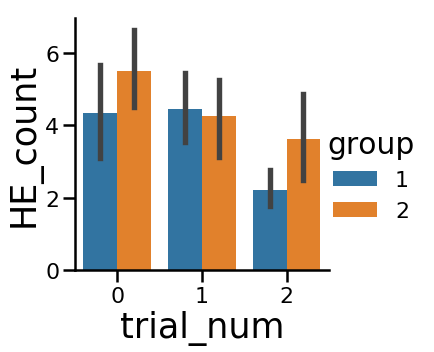

In [20]:
plt.figure(figsize=(30,10))
sns.catplot(x='trial_num', y='HE_count', data=final_data.groupby(['trial_num', 'animal_number', 'group'])['HE_count'].sum().reset_index(), hue='group', kind='bar', ci=68)

plt.show()

In [ ]:
file_path = file_paths[1]
print('file_path:', '\n', file_path, '\n')

date, animal_number, session, session_num = get_file_info(file_path)
print('date:', date, 'animal_number:', animal_number, 'session:', session, 'session_num:', session_num, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "E", "T", 'event')
print(events_and_times, '\n')

trial_times = get_trial_times_MT(events_and_times, 5,100)
print(trial_times, '\n')

trial_data = create_trial_df(events_and_times, trial_times)
print(trial_data, '\n')

bit_dic = {'reinforcement': 5, 'HE_trial': 6}
session_data = create_session_df(trial_data, bit_dic)
session_data